In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

## 1. Image Segmentation Using K-means

### 1.1. Define K-means functions

In [2]:
# define a function to initialize k centroids by randomly selecting them from the data points
def initialize_centroids(image, k):
    centroids = image.copy()
    np.random.shuffle(centroids)
    return centroids[:k]

# define a function to calculate the closest centroid for each point in image
def closest_centroid(image, centroids):
    distances = np.sqrt(((image - centroids[:, np.newaxis]) ** 2).sum(axis=2))
    return np.argmin(distances, axis=0)

# function to move centroids to the mean location assoicated with them
def move_centroids(image, closest, centroids):
    return np.array([image[closest==k].mean(axis=0) for k in range(centroids.shape[0])])

# function to convert centroids and clusters into segmented image
def create_segmented_image(image, clustered_points, centroids):
    segmented_image = list()
    for point in clustered_points:
        segmented_image.append(centroids[point])
    segmented_image = np.array(segmented_image)
    segmented_image = segmented_image.reshape(image.shape[0], image.shape[1], image.shape[2])
    segmented_image = cv2.convertScaleAbs(segmented_image)
    return segmented_image


### 1.2. K-means with K = 2

In [3]:
# read the images
home = cv2.imread('home.jpg')
home = cv2.cvtColor(home, cv2.COLOR_BGR2RGB)
flower = cv2.imread('flower.jpg')
flower = cv2.cvtColor(flower, cv2.COLOR_BGR2RGB)

# create a copy of the images and reshape them into a list of 3D pixel points
home_copy = home.copy().reshape(home.shape[0] * home.shape[1], home.shape[2])
flower_copy = flower.copy().reshape(flower.shape[0] * flower.shape[1], flower.shape[2])

# convert the list of 3d pixel points from uint8 to float
home_copy.astype(float)
flower_copy.astype(float)

array([[ 9., 11., 10.],
       [11., 13., 12.],
       [10., 15., 11.],
       ...,
       [53., 54., 22.],
       [59., 64., 32.],
       [57., 66., 35.]])

(Text(0.5, 1.0, 'Segmented Image'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

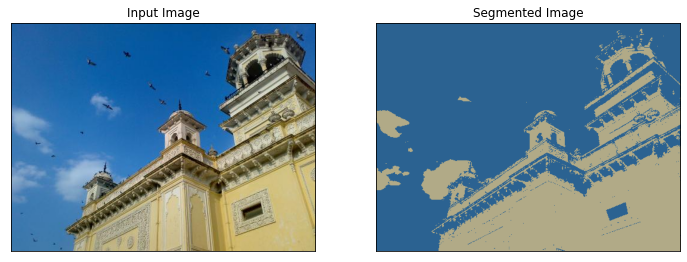

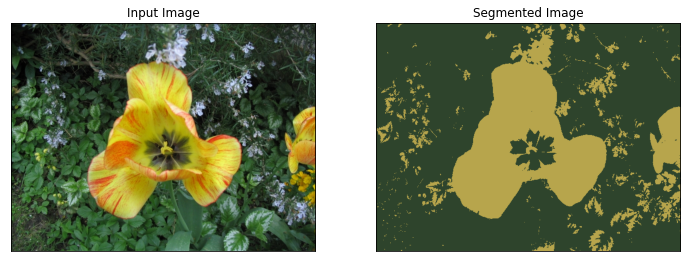

In [4]:
# apply k-means for K = 2
home_k2_centroids = initialize_centroids(home_copy, 2)
flower_k2_centroids = initialize_centroids(flower_copy, 2)
# iterate 10 times and apply K means
for i in range(10):
    home_k2_clustered_points = closest_centroid(home_copy, home_k2_centroids)
    home_k2_centroids = move_centroids(home_copy, home_k2_clustered_points, home_k2_centroids)
    flower_k2_clustered_points = closest_centroid(flower_copy, flower_k2_centroids)
    flower_k2_centroids = move_centroids(flower_copy, flower_k2_clustered_points, flower_k2_centroids)

# create segmented images
home_k2 = create_segmented_image(home, home_k2_clustered_points, home_k2_centroids)
flower_k2 = create_segmented_image(flower, flower_k2_clustered_points, flower_k2_centroids)

# plot home image
plt.figure(figsize=(12, 12))
plt.subplot(121), plt.imshow(home)
plt.title("Input Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(home_k2)
plt.title("Segmented Image"), plt.xticks([]), plt.yticks([])

# plot flower image
plt.figure(figsize=(12, 12))
plt.subplot(121), plt.imshow(flower)
plt.title("Input Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(flower_k2)
plt.title("Segmented Image"), plt.xticks([]), plt.yticks([])

### 1.3. K-means with K = 3

(Text(0.5, 1.0, 'Segmented Image'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

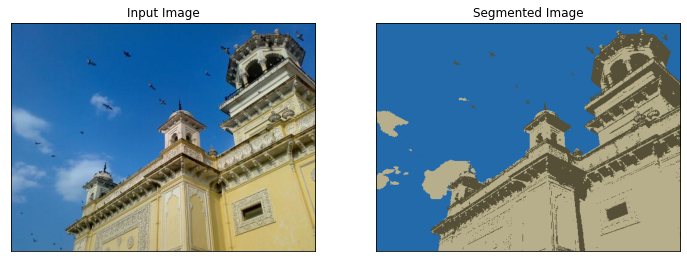

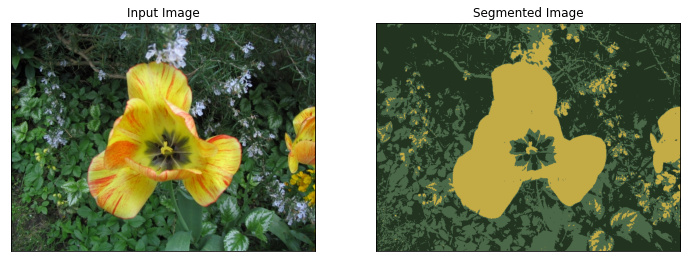

In [5]:
# apply k-means for K = 3
home_k3_centroids = initialize_centroids(home_copy, 3)
flower_k3_centroids = initialize_centroids(flower_copy, 3)
# iterate 10 times and apply K means
for i in range(10):
    home_k3_clustered_points = closest_centroid(home_copy, home_k3_centroids)
    home_k3_centroids = move_centroids(home_copy, home_k3_clustered_points, home_k3_centroids)
    flower_k3_clustered_points = closest_centroid(flower_copy, flower_k3_centroids)
    flower_k3_centroids = move_centroids(flower_copy, flower_k3_clustered_points, flower_k3_centroids)

# create segmented images
home_k3 = create_segmented_image(home, home_k3_clustered_points, home_k3_centroids)
flower_k3 = create_segmented_image(flower, flower_k3_clustered_points, flower_k3_centroids)

# plot home image
plt.figure(figsize=(12, 12))
plt.subplot(121), plt.imshow(home)
plt.title("Input Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(home_k3)
plt.title("Segmented Image"), plt.xticks([]), plt.yticks([])

# plot flower image
plt.figure(figsize=(12, 12))
plt.subplot(121), plt.imshow(flower)
plt.title("Input Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(flower_k3)
plt.title("Segmented Image"), plt.xticks([]), plt.yticks([])

## 2. Disparity

### 2.1. Read Images and Resize Them for Faster Computation

In [6]:
# read images
left = cv2.imread('aloeL.jpg')
left = cv2.cvtColor(left, cv2.COLOR_BGR2RGB)
right = cv2.imread('aloeR.jpg')
right = cv2.cvtColor(right, cv2.COLOR_BGR2RGB)

# resize images for faster computation
left = cv2.resize(left, (int(left.shape[1]*0.3), int(left.shape[0]*0.3)), cv2.INTER_AREA)
right = cv2.resize(right, (int(right.shape[1]*0.3), int(right.shape[0]*0.3)), cv2.INTER_AREA)

### 2.2. Extract 5x5 Reference Windows from Left Image

In [7]:
# extract 5x5 reference windows centered at each pixel location
ref_windows = dict()
height, width = left.shape[:2]
for i in range(2, height-2):
    for j in range(2, width-2):
        window = left[i-2:i+3, j-2:j+3]
        # key: center point, value: window
        ref_windows[(i, j)] = window

### 2.3. Compute Disparity using Sum of Squared Distance (SSD)

In [8]:
# initialize the disparity map to 48
disparity_map = np.full((height, width), 48)
# for each window in the ref_windows
for point, window in ref_windows.items():
    i = point[0]
    j = point[1]
    # initialize a dict to hold scanline windows
    sl_windows = dict()
    for j_ in range(j-47, j+1):
        if j_ >= 2:
            scanline_window = right[i-2:i+3, j_-2:j_+3]
            sl_windows[(i, j_)] = scanline_window
    # initialize a dict to hold the values of sum-of-square-distance (ssd)
    ssds = dict()   
    for sl_point, sl_window in sl_windows.items():
        window_float = window.astype(int)
        sw_float = sl_window.astype(int)
        ssd = ((window_float - sw_float)**2).sum()
        ssds[sl_point] = ssd
    # get the point (i,j)R with the min SSD
    min_ssd_point = min(ssds, key=ssds.get)
    # compute disparity
    disparity_map[i][j] = j - min_ssd_point[1]

### 2.4. Plot the Resulting Disparity Map

(Text(0.5, 1.0, 'Disparity Map of the Stereo Images'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

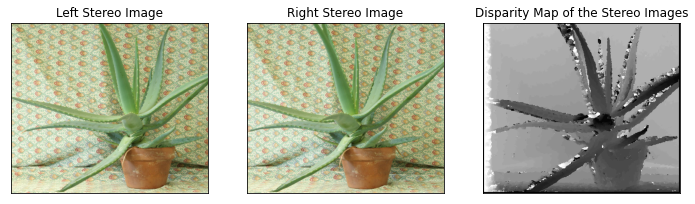

In [10]:
plt.figure(figsize=(12, 12))
plt.subplot(131), plt.imshow(left)
plt.title("Left Stereo Image"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(right)
plt.title("Right Stereo Image"), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(disparity_map, cmap="gray_r")
plt.title("Disparity Map of the Stereo Images"), plt.xticks([]), plt.yticks([])

## 3. Optical Flow

### 3.1. Read the images and the Ground Truth Flow Data

(([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

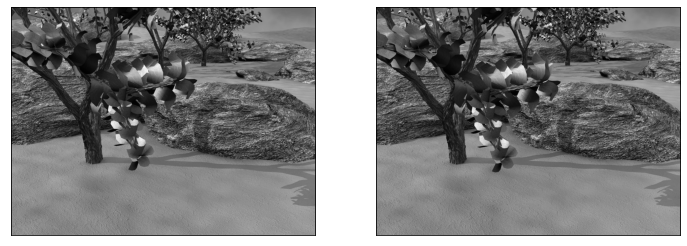

In [20]:
# read the images
frame_10 = cv2.imread('frame10.png')
frame_10 = cv2.cvtColor(frame_10, cv2.COLOR_BGR2GRAY)
frame_11 = cv2.imread('frame11.png')
frame_11 = cv2.cvtColor(frame_11, cv2.COLOR_BGR2GRAY)

# read the ground truth flow
gt = np.load('flow10.npz')['flow']

# display the initial images
plt.figure(figsize=(12, 12))
plt.subplot(121), plt.imshow(frame_10, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(frame_11, cmap='gray')
plt.xticks([]), plt.yticks([])

### 3.2. Compute Optical Flow between the two input images

In [21]:
# calculate the optical flow between the two input images for varying winsize
optical_flows = dict()
for winsize in range(5, 22, 2):
    optical_flow = cv2.calcOpticalFlowFarneback(
        prev=frame_10,
        next=frame_11,
        flow=None,
        pyr_scale=0.5,
        levels=3,
        winsize=winsize,
        iterations=3,
        poly_n=5,
        poly_sigma=1.2,
        flags=0
    )
    optical_flows[winsize] = optical_flow

### 3.3. Measure Mean Squared Error between Estimated Optical Flow and Ground Truth Optical Flow

In [23]:
# calculate Mean Squared Error (MSE) for each estimated optical flow
mses = dict()
for winsize, flow in optical_flows.items():
    mse = ((flow - gt) ** 2).mean()
    mses[winsize] = mse

### 3.4 Plot MSE

Text(0.5, 1.0, 'Mean Squared Error (MSE) vs Window Size')

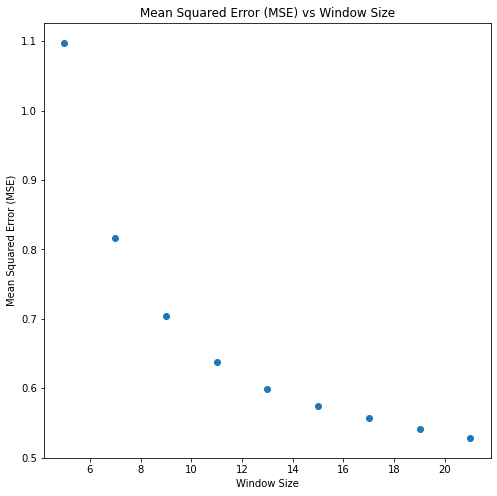

In [32]:
plt.figure(figsize=(8, 8))
plt.scatter(x=mses.keys(), y=mses.values())
plt.xlabel('Window Size')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Mean Squared Error (MSE) vs Window Size')

### 3.5 Observations

Looking at the plot `MSE vs Window Size`, we can observe that there is an exponential trendline. This exponential trend is a reverse one, meaning that as the window size increases, the mean squared error decreases.

The effect of window-size is that, having a larger window size decreases the error in the estimated optical flow. Therefore, we can say that it is better to keep the window size larger when we want to have more accurate optical flow calculations.